In [80]:
import functools
import os
import time
from typing import List

import matplotlib.pyplot as plt

plt.rcParams.update({"font.family": "serif", "font.size": 15})
%matplotlib inline

import cirq
import networkx as nx
import numpy as np
import qiskit
import qiskit_aer
from mitiq import benchmarks, pec, zne

In [81]:
# !pip list -- local

In [82]:
# Option to use a noisy simulator instead of hardware backend.
use_noisy_simulator: bool = True

# Minimum depth circuit to use.
min_depth: int = 1
# Random seed for circuit generation.
seed: int = 1

# Minimum noise scale factor.
min_scale_factor: int = 1
# Maximum noise scale factor.
max_scale_factor: int = 3

# Step between noise scale factors.
step_scale_factor: int = 1

# Total number of shots to use.
# For PEC, the shots per circuit is shots / num_samples.
# For ZNE, the shots per circuit is shots / len(scale_factors).
shots: int = 10_000
# Number of samples (circuits) to use in PEC.
num_samples: int = 100

# Display verbose output.

verbose: bool = True
# Give queue updates every this many seconds when running on hardware device.
verbose_update_time: int = 30

# Save data (cnot_counts, oneq_counts, true_values, noisy_values, zne_values, etc.).
save_data: bool = True

In [83]:
# Benchmark circuit type. Supported types are "rb" and "mirror".
# RB circuits are only suppported for 1 and 2 qubit circuits.
circuit_type: str = "mirror"

# Qubits to use on the experiment.
num_qubits = 6
qubits = [j for j in range(num_qubits)]

# Split qubits into 2-qubit pairs (assuming a chain connectivity).
rb_pattern = [[qa, qb] for qa, qb in zip(qubits[0:-1:2], qubits[1::2])]
if len(qubits) % 2 == 1:
    # For an odd number of qubits, append final individual qubit to the RB pattern.
    rb_pattern.append([qubits[-1]])
print("Qubit indeces:", qubits)
print("RB pattern:", rb_pattern)

# Maximum depth circuit to use.
max_depth: int = 10

# Step to create a list of depths to run at.
step_depth: int = 2

# Average results over this many trials (circuit instances) at each depth.
trials: int = 4

Qubit indeces: [0, 1, 2, 3, 4, 5]
RB pattern: [[0, 1], [2, 3], [4, 5]]


In [84]:
# Hardware backend device type. Supported types are currently "ibmq" but more could be added.
hardware_type: str = "ibmq"

backend = {
    "ibmq": "ibmq_lima",
}.get(hardware_type)

In [85]:
if hardware_type == "ibmq":
    # Physical qubits of ibmq-kolkata with a chain-like connectivity.
    ibm_lima_ordering = [0, 1, 3, 4, 2]
    ibm_kolkata_ordering = [
        0,
        1,
        4,
        7,
        10,
        12,
        15,
        18,
        21,
        23,
        24,
        25,
        22,
        19,
        16,
        14,
        11,
        8,
        5,
        3,
        2,
    ]

    if len(qubits) <= 5:
        # Assume ibmq-lima device. Take n adjacent physical qubits.
        physical_ibm_qubits = ibm_lima_ordering[: len(qubits)]
    elif len(qubits) <= len(ibm_kolkata_ordering) and len(qubits)> 5:
        # Assume ibmq-kolkata device. Take n adjacent physical qubits.
        physical_ibm_qubits = ibm_kolkata_ordering[: len(qubits)]
    else:
        raise ValueError(f"Number of qubits {num_qubits} too large.")

    print("IBM physical qubits:", physical_ibm_qubits)

IBM physical qubits: [0, 1, 4, 7, 10, 12]


In [86]:
# Error mitigation type. Supported typed are "zne" and "pec".
mitigation_type: str = "pec"

fold_method = zne.scaling.fold_global

depths = list(range(min_depth, max_depth + 1, step_depth))

scale_factors = tuple(range(min_scale_factor, max_scale_factor + 1, step_scale_factor))

print(f"Depths: {depths}")
print(f"Scale factors: {scale_factors}")

Depths: [1, 3, 5, 7, 9]
Scale factors: (1, 2, 3)


In [87]:
computer = nx.Graph()

# Assume chain-like connectivity
computer.add_edges_from([(qa, qb) for qa, qb in zip(qubits[:-1], qubits[1:])])

# Add reversed edges to computer graph.
# This is important to represent CNOT gates with target and control reversed.
computer = nx.to_directed(computer)

# Get the backend to run on and a simulated backend for comparing results.
if use_noisy_simulator:
    from qiskit.providers.fake_provider import GenericBackendV2
    # can use GenericBackendV2 for more flexibility

    noisy_backend = GenericBackendV2(num_qubits=10)

# Specify both the hardware device and device architecture (computer):
else:
    provider = qiskit.IBMQ.load_account()
    noisy_backend = provider.get_backend(backend)
    print(f"View {backend} job status at https://quantum-computing.ibm.com/jobs")

# Check if RB-pattern is consistent with device topology.
for edge in rb_pattern:
    if len(edge) == 2:
        if edge not in computer.edges:
            raise ValueError(
                "The option rb_pattern is not consistent with the device topology."
            )

# Set ideal backends for simulator-selected options.
# ideal_backend = qiskit.Aer.get_backend("aer_simulator")
ideal_backend = qiskit_aer.AerSimulator()


print("Computer connectivity (used only for mirror circuits):", computer.edges)
print("Noisy backend", noisy_backend)
print("Ideal backend", ideal_backend)

Computer connectivity (used only for mirror circuits): [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), (4, 5), (5, 4)]
Noisy backend <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000220E4C92540>
Ideal backend AerSimulator('aer_simulator')


In [88]:
def named_qubit_to_line_qubit(named_qubit: str) -> cirq.LineQubit:
    """Extract qubit number assuming "_" is used as a word separator."""
    digits = [int(s) for s in named_qubit.name.split("_") if s.isdigit()]
    if len(digits) == 1:
        return cirq.LineQubit(digits[0])
    else:
        raise RuntimeError("Failed to identify qubit number.")

In [89]:
if circuit_type == "rb":

    def get_circuit(depth: int, seed: int) -> tuple[qiskit.QuantumCircuit, str]:
        circuit = benchmarks.generate_rb_circuits(
            n_qubits=2, num_cliffords=depth, seed=seed, return_type="qiskit"
        )[0]

        return circuit, "00"

elif circuit_type == "mirror":

    def get_circuit(depth: int, seed: int) -> tuple[qiskit.QuantumCircuit, str]:
        circuit, correct_bitstring = benchmarks.generate_mirror_circuit(
            nlayers=depth,
            two_qubit_gate_prob=1.0,
            connectivity_graph=computer,
            two_qubit_gate_name="CNOT",
            seed=seed,
            return_type="qiskit",
        )

        # Reversed because Qiskit is wrong endian.
        return circuit, "".join(map(str, correct_bitstring[::-1]))

In [90]:
def get_cnot_error(edge: tuple[int, int] = None) -> float:
    # If we use a simulator, we can't get any error probability from any specific
    # device so we hardcode a small "reasonable" CNOT error probability.
    # if use_noisy_simulator and hardware_type != "ibmq":
    cnot_error_prob = 0.01

    # cnot_error_prob = noisy_backend.properties().gate_error("cx", qubits=edge)

    print(f"cnot_error_prob for edge {edge}: {cnot_error_prob}")
    return cnot_error_prob


def get_cnot_representation(edge: tuple[int, int]) -> pec.OperationRepresentation:
    cnot_circuit = cirq.Circuit(
        cirq.CNOT(
            cirq.NamedQubit(f"q_{str(edge[0])}"),
            cirq.NamedQubit(f"q_{str(edge[1])}"),
        )
    )

    rep_exact_prob = 1 - np.sqrt(1 - get_cnot_error(edge))
    return pec.represent_operation_with_local_depolarizing_noise(
        cnot_circuit,
        noise_level=rep_exact_prob,
    )


def get_representations(computer: nx.Graph) -> list[pec.OperationRepresentation]:
    return [get_cnot_representation(edge) for edge in computer.edges]

In [91]:
def get_num_cnot_count(circuit: qiskit.QuantumCircuit) -> int:
    """Determine number of cnot gates in a given `Circuit` object."""

    return circuit.count_ops().get("cx")


def get_avg_cnot_count(circuits: list[qiskit.QuantumCircuit]) -> float:
    """Determine average number of cnot gates present in
    list of `QuantumCircuit` objects."""

    return np.average([c.count_ops().get("cx") for c in circuits])


def get_oneq_count(circuit: qiskit.QuantumCircuit) -> int:
    return len(circuit) - get_num_cnot_count(circuit)

In [92]:
def execute(
    circuits: qiskit.QuantumCircuit | list[qiskit.QuantumCircuit],
    backend,
    shots: int,
    correct_bitstring: str,
    verbose: bool = verbose,
    is_noisy: bool = True,
) -> List[float]:
    """Executes the input circuit(s) and returns ⟨A⟩, where
    A = |correct_bitstring⟩⟨correct_bitstring| for each circuit.
    """
    if not isinstance(circuits, list):
        circuits = [circuits]

    if verbose:
        # Calculate average number of CNOT gates per circuit.
        print(f"Executing {len(circuits)} circuit(s) on {backend}.")
        print(f"Average cnot count in circuits: {get_avg_cnot_count(circuits)}")

    # Store all circuits to run in list to be returned.
    to_run: list[qiskit.QuantumCircuit] = []

    for circuit in circuits:
        circuit_to_run = circuit.copy()

        circuit_to_run.measure_all()
        to_run.append(
            qiskit.transpile(
                circuit_to_run,
                backend=backend,
                initial_layout=physical_ibm_qubits,
                optimization_level=0,  # Otherwise RB circuits are simplified to empty circuits.
            )
        )

    if verbose:
        # Calculate average number of CNOT gates per compiled circuit.
        print(f"Average cnot count in compiled circuits: {get_avg_cnot_count(to_run)}")

    # Run and get counts.
    job = backend.run(
        to_run,
        # Reset qubits to ground state after each sample.
        init_qubits=True,
        shots=shots,
    )
    # IBMQ uses online queue for processing jobs.
    if verbose and not use_noisy_simulator:
        time.sleep(3)
        while not job.in_final_state():
            print(f"Queue position: {job.queue_position()}")
            time.sleep(verbose_update_time)
        print()

    print(f"Correct bitstring: {correct_bitstring}")
    if len(circuits) == 1:
        return [job.result().get_counts().get(correct_bitstring, 0.0) / shots]
    return [
        count.get(correct_bitstring, 0.0) / shots for count in job.result().get_counts()
    ]

In [93]:
cnot_counts, oneq_counts = [], []
true_values, noisy_values = [], []
zne_values, pec_values = [], []

noise_scaled_expectation_values = []

for depth in depths:
    print("Status: On depth", depth, end="\n\n")

    cnot_depth_counts, oneq_depth_counts = [], []
    true_depth_values, noisy_depth_values = [], []
    zne_depth_values, pec_depth_values = [], []

    noise_scaled_expectation_depth_values = []

    for trial in range(trials):
        # Local seed is calculated in this way to ensure that we don't get repeat values in loop.
        local_seed = 10**6 * depth + 10**3 * seed + trial

        circuit, correct_bitstring = get_circuit(depth, local_seed)

        (true_value,) = execute(
            circuit,
            ideal_backend,
            shots,
            correct_bitstring,
            verbose=verbose,
            is_noisy=False,
        )
        (noisy_value,) = execute(
            circuit,
            noisy_backend,
            shots,
            correct_bitstring,
            verbose=verbose,
            is_noisy=True,
        )

        if mitigation_type == "zne":
            zne_executor = functools.partial(
                execute,
                backend=noisy_backend,
                shots=shots // len(scale_factors),
                correct_bitstring=correct_bitstring,
                verbose=verbose,
            )
            richardson_factory = zne.inference.RichardsonFactory(
                scale_factors=scale_factors
            )
            zne_value = zne.execute_with_zne(
                circuit,
                zne_executor,
                scale_noise=fold_method,
                factory=richardson_factory,
            )
            zne_depth_values.append(zne_value)
            noise_scaled_expectation_depth_values.extend(
                richardson_factory.get_expectation_values()
            )

        elif mitigation_type == "pec":
            pec_executor = functools.partial(
                execute,
                backend=noisy_backend,
                shots=shots // num_samples,
                correct_bitstring=correct_bitstring,
                verbose=verbose,
            )
            pec_value = pec.execute_with_pec(
                circuit,
                pec_executor,
                representations=get_representations(computer),
                num_samples=num_samples,
                random_state=local_seed,
            )
            pec_depth_values.append(pec_value)

        cnot_depth_counts.append(get_num_cnot_count(circuit))
        oneq_depth_counts.append(get_oneq_count(circuit))

        true_depth_values.append(true_value)
        noisy_depth_values.append(noisy_value)

    cnot_counts.append(cnot_depth_counts)
    oneq_counts.append(oneq_depth_counts)

    true_values.append(true_depth_values)
    noisy_values.append(noisy_depth_values)

    noise_scaled_expectation_values.append(noise_scaled_expectation_depth_values)

    if mitigation_type == "zne":
        zne_values.append(zne_depth_values)
    elif mitigation_type == "pec":
        pec_values.append(pec_depth_values)

Status: On depth 1

Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 000111
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000220E4C92540>.
Average cnot count in circuits: 4.0


TranspilerError: "The 'layout' must be full (with ancilla)."

In [ ]:
avg_true_values = np.average(true_values, axis=1)
avg_noisy_values = np.average(noisy_values, axis=1)

std_true_values = np.std(true_values, axis=1, ddof=1)
std_noisy_values = np.std(noisy_values, axis=1, ddof=1)

if mitigation_type == "zne":
    avg_zne_values = np.average(zne_values, axis=1)
    std_zne_values = np.std(zne_values, axis=1, ddof=1)
elif mitigation_type == "pec":
    avg_pec_values = np.average(pec_values, axis=1)
    std_pec_values = np.std(pec_values, axis=1, ddof=1)

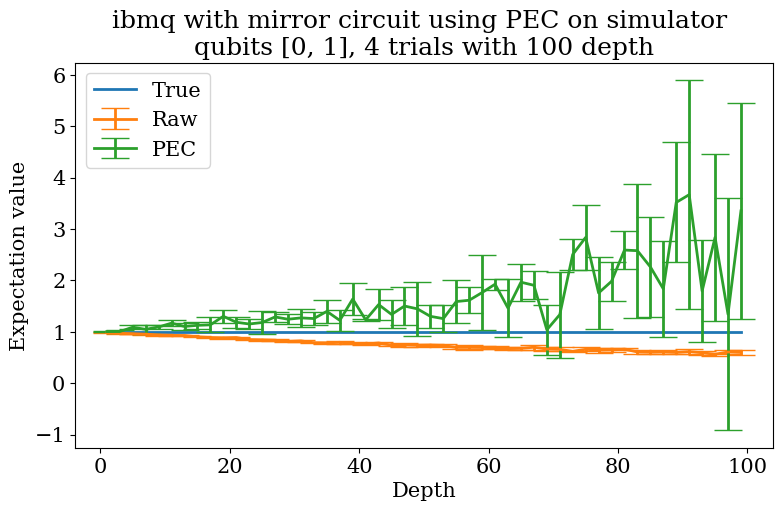

In [ ]:
plt.figure(figsize=(9, 5))

kwargs = {"capsize": 10, "lw": 2}

plt.plot(depths, avg_true_values, label="True", lw=2)
plt.errorbar(depths, avg_noisy_values, yerr=std_noisy_values, label="Raw", **kwargs)

if mitigation_type == "zne":
    plt.errorbar(depths, avg_zne_values, yerr=std_zne_values, label="ZNE", **kwargs)
elif mitigation_type == "pec":
    plt.errorbar(depths, avg_pec_values, yerr=std_pec_values, label="PEC", **kwargs)

plt.title(
    f"""{hardware_type} with {circuit_type} circuit using {mitigation_type.upper()} {"on simulator" if use_noisy_simulator else ""} \nqubits {qubits}, {trials} trials with {max_depth} depth"""
)
plt.xlabel("Depth")
plt.ylabel("Expectation value")
plt.savefig(f"{hardware_type}_{mitigation_type}_{circuit_type}.pdf")
plt.legend()

In [ ]:
import numpy as np
import os

# Create a sample array
data = noise_scaled_expectation_values
time_key = "_" + "_".join(time.asctime().split())
print(time_key[-4])
# Specify the directory and filename
directory = f"{hardware_type}_{mitigation_type}_{circuit_type}_nqubits_{len(qubits)}_mindepth_{min_depth}_maxdepth_{max_depth}_shots_{shots}_trials_{trials}"
try:
    os.mkdir(directory)
except FileExistsError:
    pass
filename = "noise_scaled_expectation_values_Thu_Apr_10_11_16_05_2025.txt"
print(filename)
filepath = os.path.join(directory, filename)
print(filepath)
# Save the array to the specified location
np.savetxt(filepath, data)

2
noise_scaled_expectation_values_Thu_Apr_10_11_16_05_2025.txt
ibmq_pec_mirror_nqubits_2_mindepth_1_maxdepth_100_shots_10000_trials_4\noise_scaled_expectation_values_Thu_Apr_10_11_16_05_2025.txt


In [ ]:
if save_data:
    dir_name = f"{hardware_type}_{mitigation_type}_{circuit_type}_nqubits_{len(qubits)}_mindepth_{min_depth}_maxdepth_{max_depth}_shots_{shots}_trials_{trials}"
    time_key = "_" + "_".join(time.asctime().split())
    # print(time_key)
    # print(dir_name)
    try:
        os.mkdir(dir_name)
    except FileExistsError:
        pass
    except FileNotFoundError:
        print(f"Error: A parent directory in the path does not exist.")

    print(len(os.path.join(dir_name, "noise_scaled_expectation_values" + time_key + ".txt")))

    
    np.savetxt(
        os.path.join(dir_name, "noise_scaled_expectation_values" + time_key + ".txt"),
        noise_scaled_expectation_values,
    )
    np.savetxt(os.path.join(dir_name, "cnot_counts" + time_key + ".txt"), cnot_counts)
    np.savetxt(os.path.join(dir_name, "oneq_counts" + time_key + ".txt"), oneq_counts)
    np.savetxt(os.path.join(dir_name, "true_values" + time_key + ".txt"), true_values)
    np.savetxt(os.path.join(dir_name, "noisy_values" + time_key + ".txt"), noisy_values)
    if mitigation_type == "zne":
        np.savetxt(os.path.join(dir_name, "zne_values" + time_key + ".txt"), zne_values)
    elif mitigation_type == "pec":
        np.savetxt(os.path.join(dir_name, "pec_values" + time_key + ".txt"), pec_values)

    print("Data saved succesfully in", dir_name)

131


OSError: [Errno 22] Invalid argument: 'ibmq_pec_mirror_nqubits_2_mindepth_1_maxdepth_100_shots_10000_trials_4\\noise_scaled_expectation_values_Fri_Apr_11_12:19:16_2025.txt'

In [ ]:
# if save_data:
#     dir_name = f"{hardware_type}_{mitigation_type}_{circuit_type}_nqubits_{len(qubits)}_mindepth_{min_depth}_maxdepth_{max_depth}_shots_{shots}_trials_{trials}"
#     time_key = "_" + "_".join(time.asctime().split())

#     try:
#         os.mkdir(dir_name)
#     except FileExistsError:
#         pass
#     except FileNotFoundError:
#         print(f"Error: A parent directory in the path does not exist.")    
    
#     np.savetxt(
#         os.path.join(dir_name, "noise_scaled_expectation_values" + time_key + ".txt"),
#         noise_scaled_expectation_values,
#     )
#     np.savetxt(os.path.join(dir_name, "cnot_counts" + time_key + ".txt"), cnot_counts)
#     np.savetxt(os.path.join(dir_name, "oneq_counts" + time_key + ".txt"), oneq_counts)
#     np.savetxt(os.path.join(dir_name, "true_values" + time_key + ".txt"), true_values)
#     np.savetxt(os.path.join(dir_name, "noisy_values" + time_key + ".txt"), noisy_values)
#     if mitigation_type == "zne":
#         np.savetxt(os.path.join(dir_name, "zne_values" + time_key + ".txt"), zne_values)
#     elif mitigation_type == "pec":
#         np.savetxt(os.path.join(dir_name, "pec_values" + time_key + ".txt"), pec_values)

#     print("Data saved succesfully in", dir_name)

OSError: [Errno 22] Invalid argument: 'ibmq_pec_mirror_nqubits_5_mindepth_1_maxdepth_30_shots_10000_trials_4\\cnot_counts_Thu_Apr_10_10:41:29_2025.txt'